# count stories/comments in the dataset

In [ ]:
import json

def analyze_data(dataset_json_filename):
    with open(dataset_json_filename, 'r') as f:
        data = json.load(f)

    total_stories = len(data['stories'])
    total_kids = sum(len(story.get('kids', [])) for story in data['stories'])

    print(f"====== File: {dataset_json_filename} ==")
    print(f"Stories found: {total_stories}")
    print(f"Total comments (kids): {total_kids}")


In [ ]:
analyze_data('../../data/sampled_hn_stories_dataset.json')

====== File: ../../data/sampled_hn_stories_dataset.json ==
Stories found: 225
Total comments (kids): 3988


In [ ]:
analyze_data(HN_STORIES_JSON)
analyze_data(HN_STORIES_GH_JSON)

====== File: ../../data/hn_stories_dataset_final.json ==
Stories found: 4645
Total comments (kids): 82250
====== File: ../../data/hn_stories_dataset_gh_final.json ==
Stories found: 354
Total comments (kids): 4707


# visualize comment distribution

In [ ]:
import matplotlib.pyplot as plt

def visualize_comment_distribution(title, progress_filename):
    with open(progress_filename, 'r') as f:
        data = json.load(f)

    stories = data['stories']
    total_stories = len(stories)
    total_kids = sum(len(story.get('kids', [])) for story in stories)

    # Calculate comments per story
    comments_per_story = [len(story.get('kids', [])) for story in stories]

    # Create histogram
    plt.figure(figsize=(12, 6))
    plt.hist(comments_per_story, bins=100, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Stories')

    # Add mean line
    mean_comments = sum(comments_per_story) / len(comments_per_story)
    plt.axvline(mean_comments, color='r', linestyle='dashed', linewidth=2)
    plt.text(mean_comments*1.1, plt.ylim()[1]*0.9, f'Mean comments per story: {mean_comments:.2f}', color='r')

    # Add some stats as text
    stats_text = f'Total Stories: {total_stories}\nTotal Comments: {total_kids}\nMean Comments per Story: {mean_comments:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
    plt.plot()

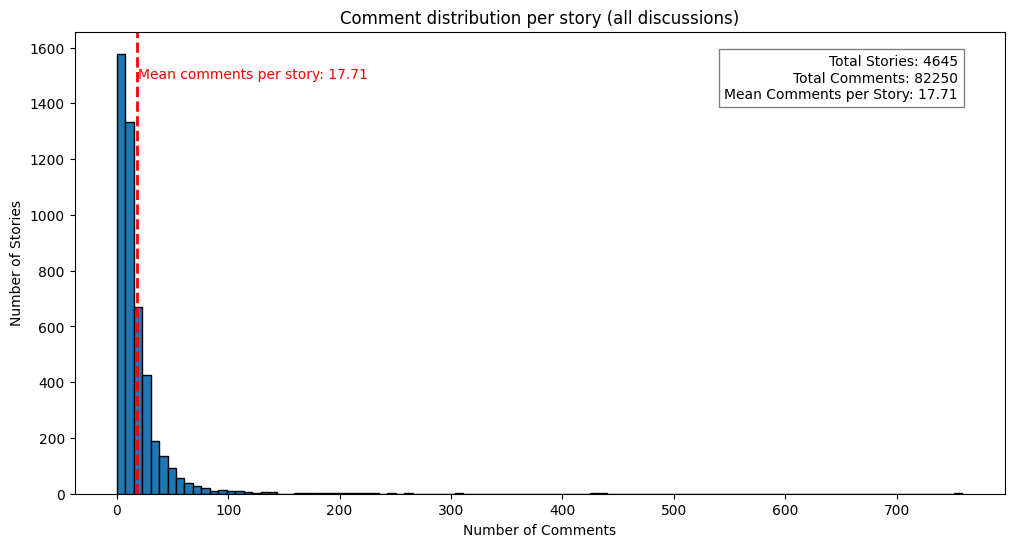

In [ ]:
# Analyze the data
HN_STORIES_JSON = ''
visualize_comment_distribution('Comment distribution per story (all discussions)',
                               HN_STORIES_JSON)

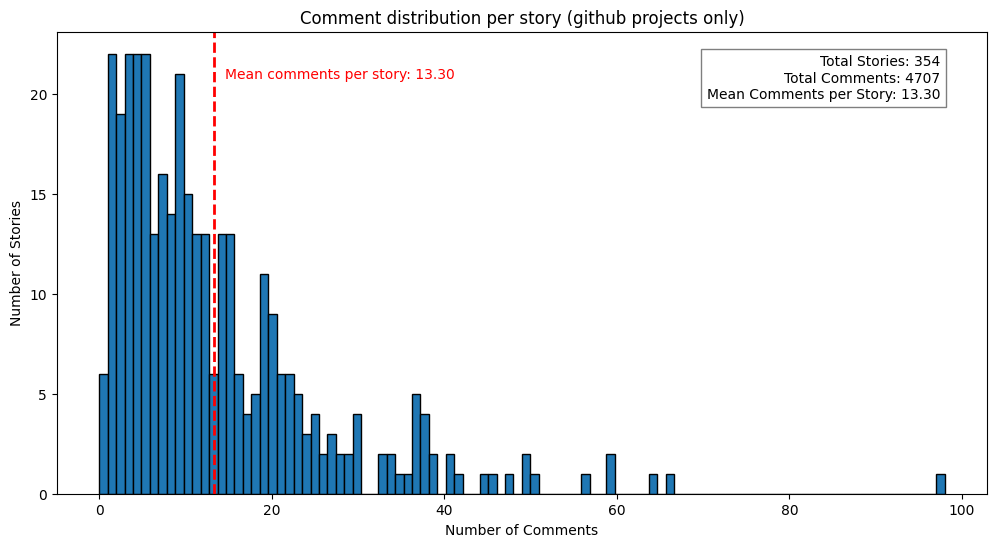

In [ ]:
HN_STORIES_GH_JSON = ''
visualize_comment_distribution('Comment distribution per story (github projects only)',
                               HN_STORIES_GH_JSON)

# graphing

## graphing total hackernews stories over time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

plt.rcParams.update({'font.size': 25})

def plot_discussions_histogram(title, csv_file_path, is_github_source=False, bin_sizes=[7, 14, 30]):
    """
    Plot histograms of AI discussions over time from a CSV file with three different bin sizes.

    Args:
    title (str): The graphs' titles
    csv_file_path (str): The path to the CSV file
    is_github_source (bool): Whether the data is from GitHub-filtered CSV or full dataset
    bin_sizes (list): List of bin sizes in days for the histograms
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Create the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))
    axes = [ax1, ax2, ax3]

    # Source type for title
    source_type = "GitHub discussions" if is_github_source else "all discussions"

    for ax, bin_size_days in zip(axes, bin_sizes):
        # Calculate number of bins
        total_days = (end_date - start_date) / (24 * 60 * 60)
        bins = int(total_days / bin_size_days)

        # Create the histogram
        n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

        # Format x-axis ticks as dates
        def timestamp_to_date(timestamp):
            return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

        num_ticks = 12
        tick_locations = np.linspace(start_date, end_date, num_ticks)
        ax.set_xticks(tick_locations)
        ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

        # ax.set_title(f'Bin Size: {bin_size_days} days')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Discussions')
        ax.tick_params(axis='x', rotation=45)

        # Add vertical line for ChatGPT release
        chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
        ax.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
        ax.legend()
        ax.grid(visible=True, alpha=0.7)

    # Adjust spacing and title position
    plt.suptitle(f'{title} ({source_type})', fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.95)  # Ensures suptitle is within bounds
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space at the top to avoid overlap

    # Save figure with appropriate filename
    source_indicator = 'github' if is_github_source else 'all'
    plt.savefig(f'hn_trends_{source_indicator}.png')
    plt.show()


graphing raw hackernews stories dataset

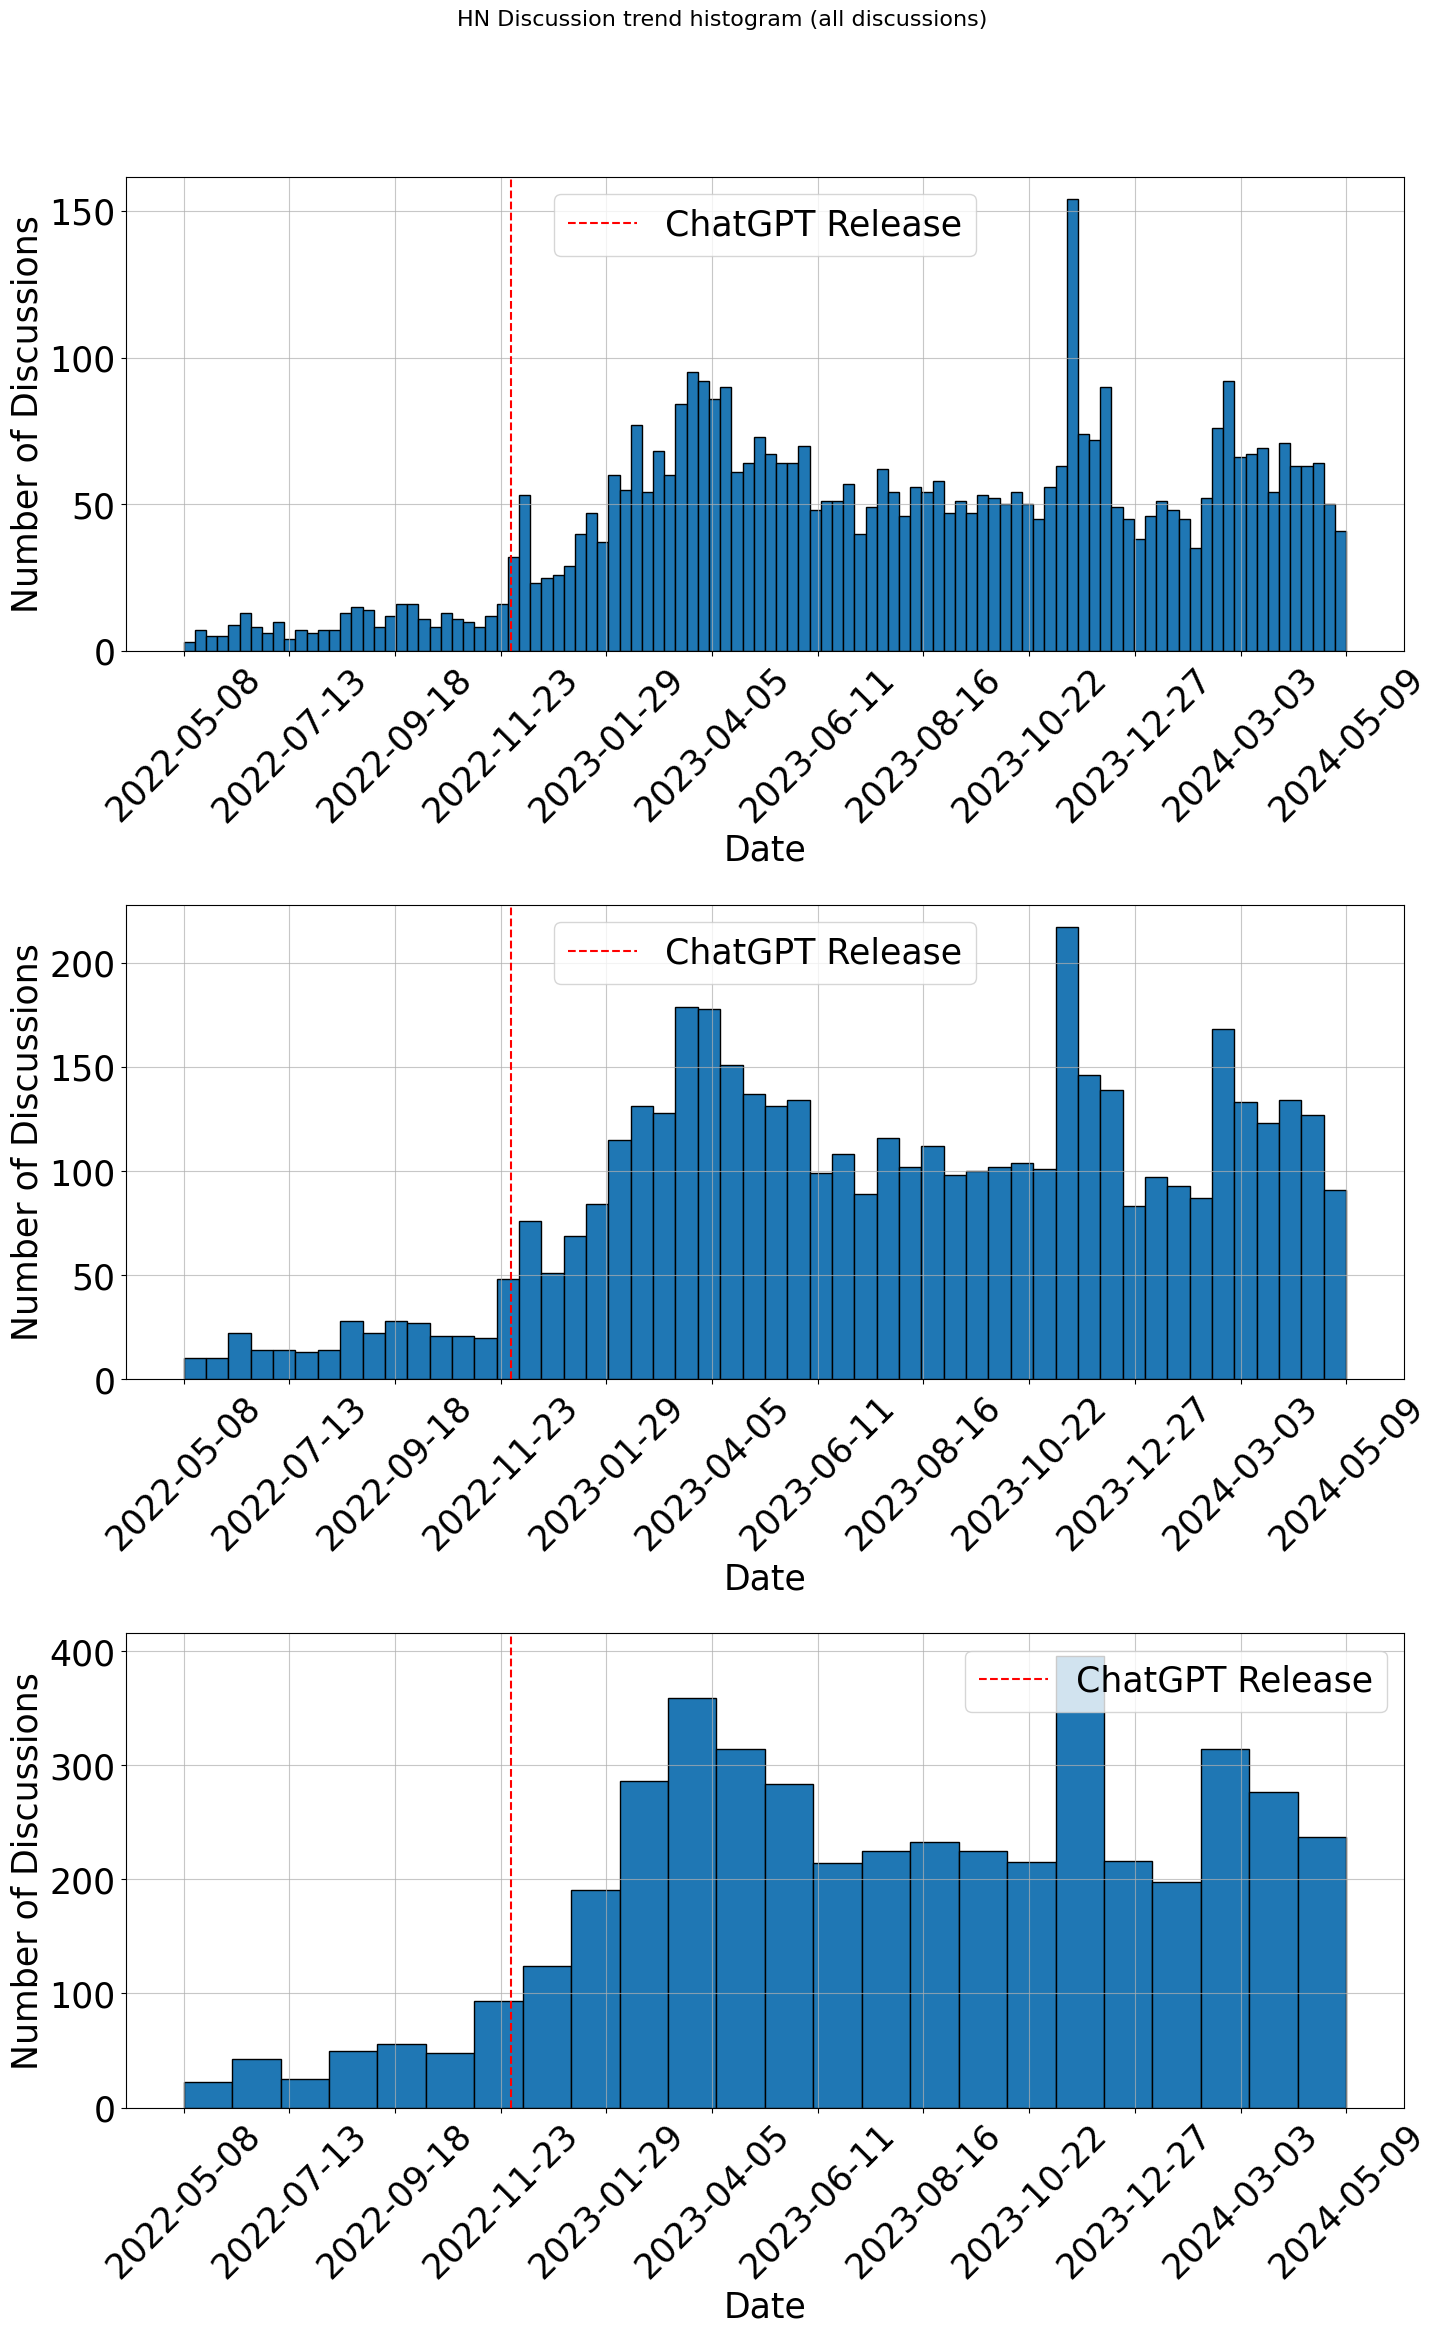

In [ ]:
# For all discussions
HN_STORIES_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_freq_analysis/rq1_stories_all.csv'
plot_discussions_histogram('HN Discussion trend histogram', HN_STORIES_CSV, is_github_source=False)

graphing github-only hackernews dataset

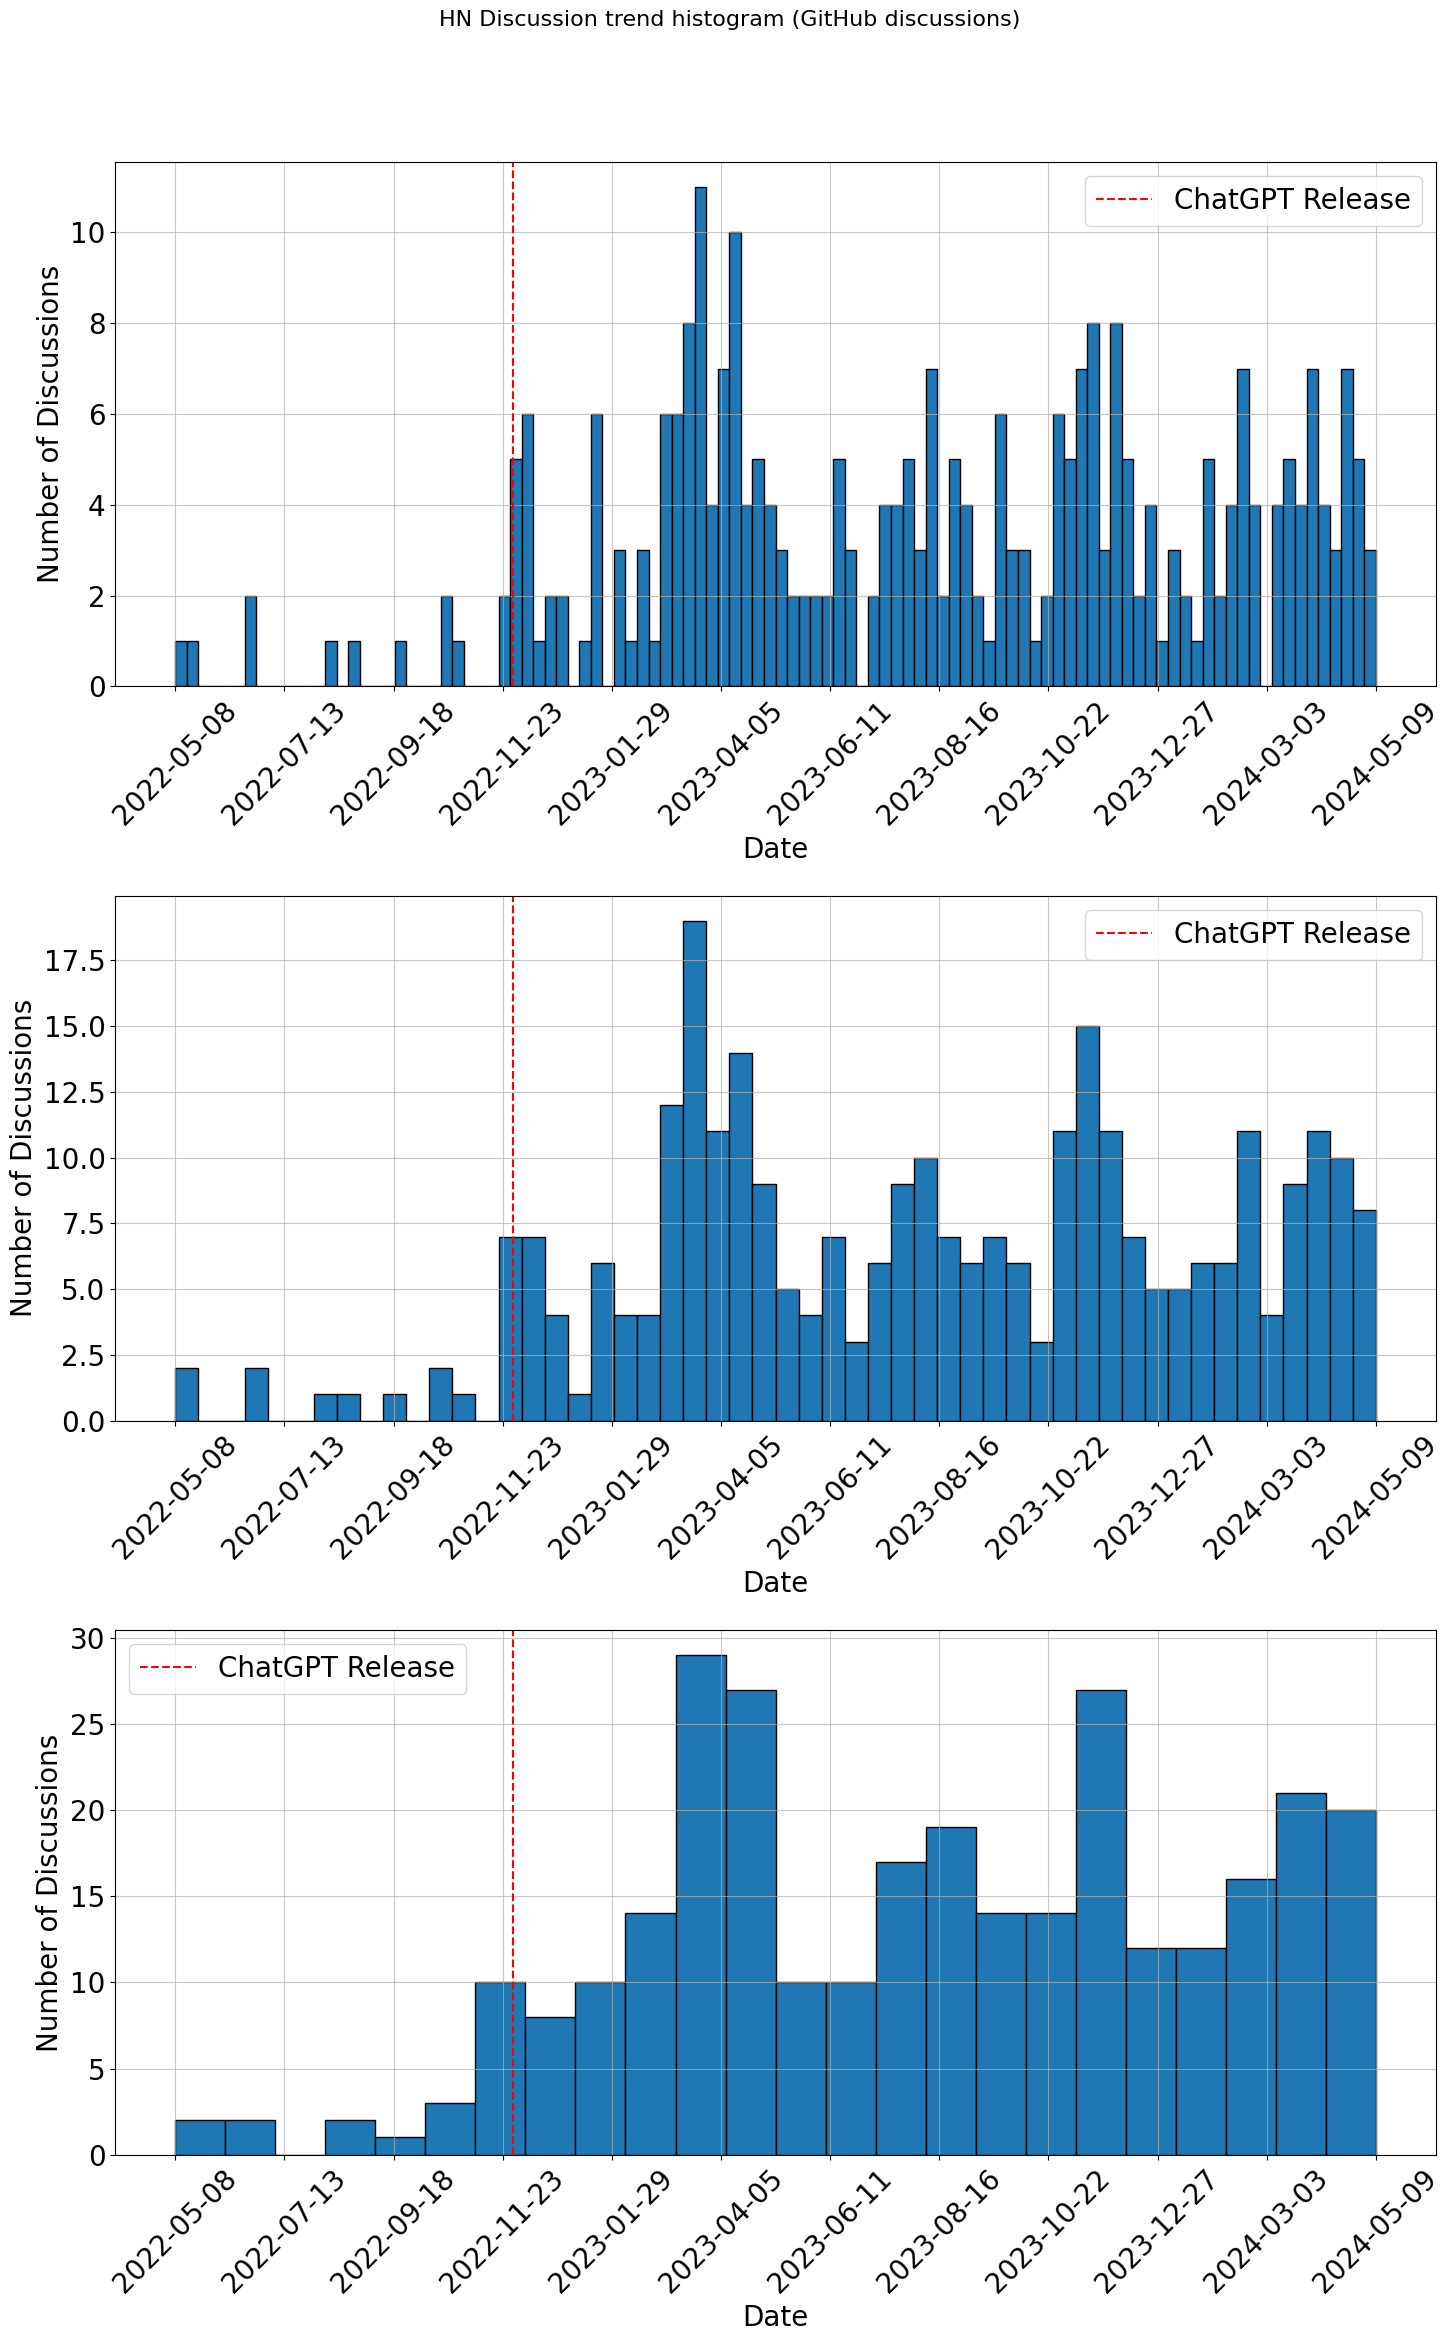

In [ ]:
# For GitHub-only discussions
HN_STORIES_GH_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_freq_analysis/rq1_stories_github.csv'
plot_discussions_histogram('HN Discussion trend histogram', HN_STORIES_GH_CSV, is_github_source=True)

## graphing by keywords

In [ ]:
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


def plot_discussions_histogram_keywords(title, csv_file_path, keyword):
    """
    Plot a histogram of AI discussions over time from a CSV file with a bin size of 14 days.

    Args:
    title (str): The graph's title.
    csv_file_path (str): The path to the CSV file.
    keyword (str): The keyword to search for in the title column.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the dataframe based on the keyword
    df = df[df['title'].str.contains(keyword, case=False, regex=True)]

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Create the figure
    fig, ax = plt.subplots(figsize=(15, 7))

    # Set bin size to 14 days
    bin_size_days = 14
    total_days = (end_date - start_date) / (24 * 60 * 60)
    bins = int(total_days / bin_size_days)

    # Create the histogram
    n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

    # Format x-axis ticks as dates
    def timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    num_ticks = 5
    tick_locations = np.linspace(start_date, end_date, num_ticks)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

    ax.set_title(f'Bin Size: {bin_size_days} days', y=1.0)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Discussions')
    ax.tick_params(axis='x', rotation=45)

    # Add vertical line for ChatGPT release
    chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
    ax.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
    ax.legend()

    # Adjust the position of the main title
    plt.suptitle(f'{title} Keyword: {keyword}', fontsize=16, y=1.0)
    # plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust bottom and top to prevent overlap
    plt.savefig(f'hn_trends_keyword_{keyword}.png')
    plt.show()


In [ ]:
# open txt file containing keywords
with open('keywords.txt', 'r') as f:
    keywords = f.read().splitlines()

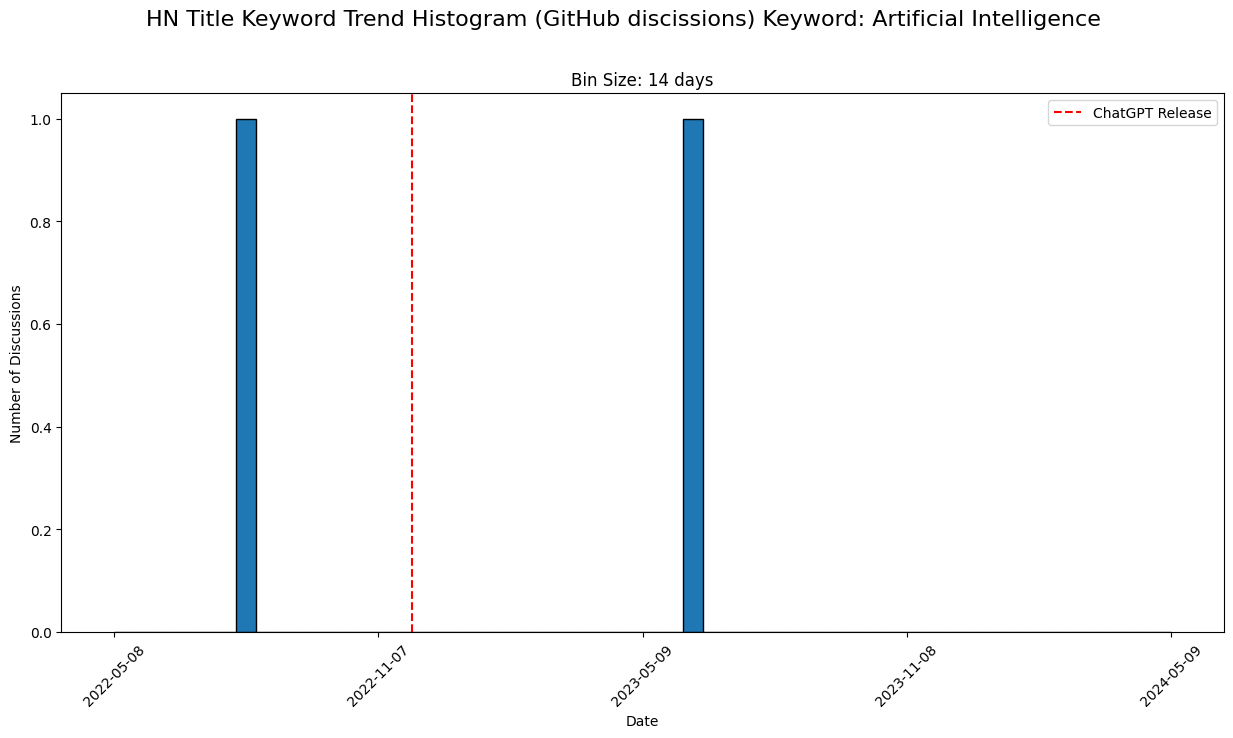

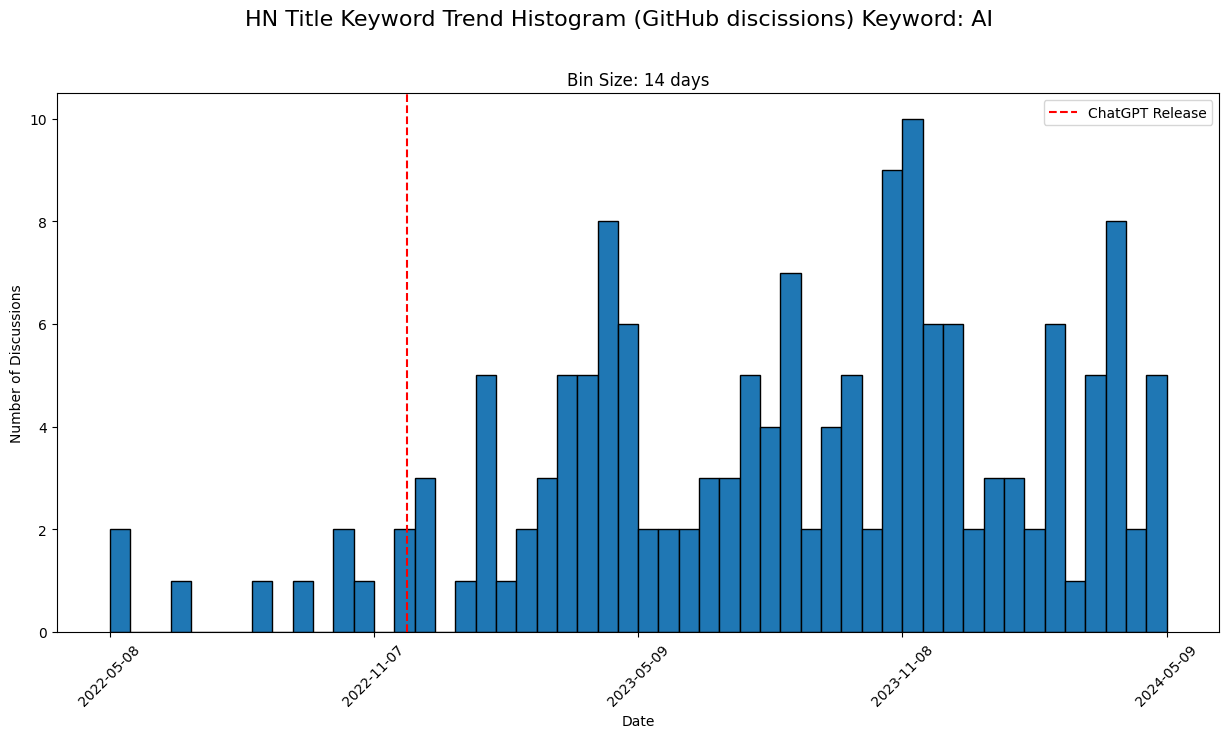

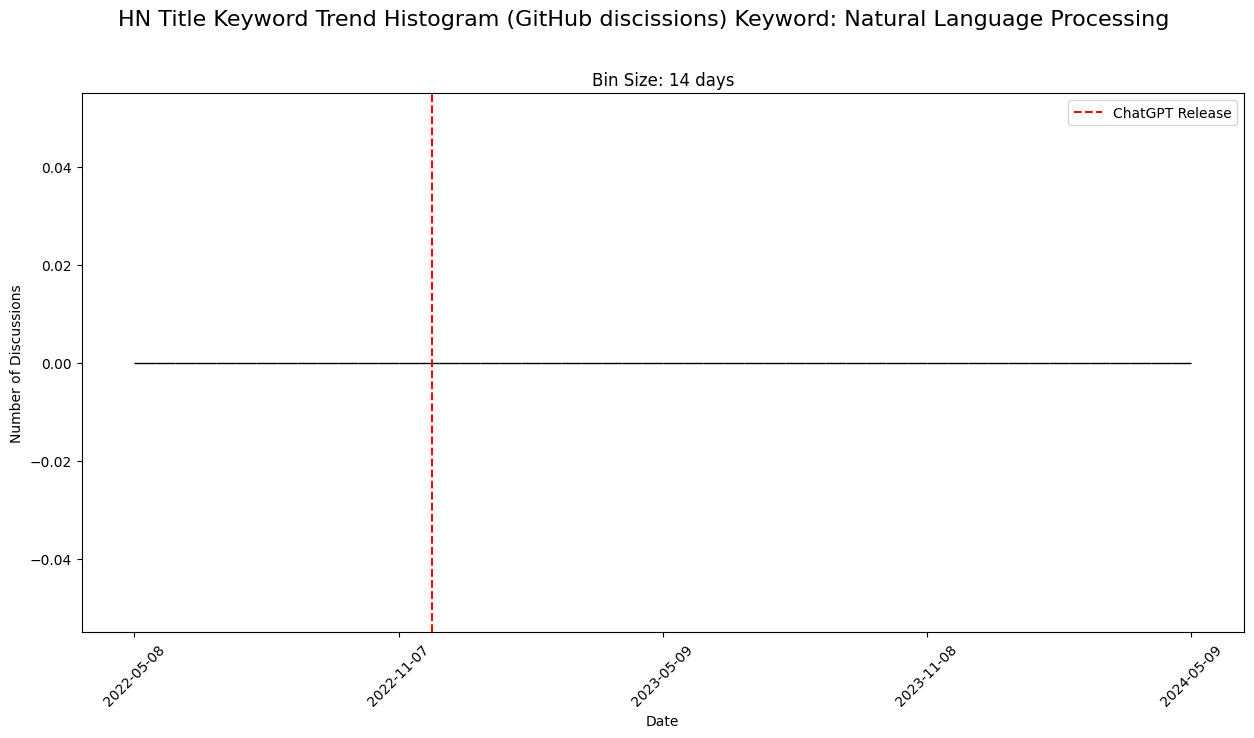

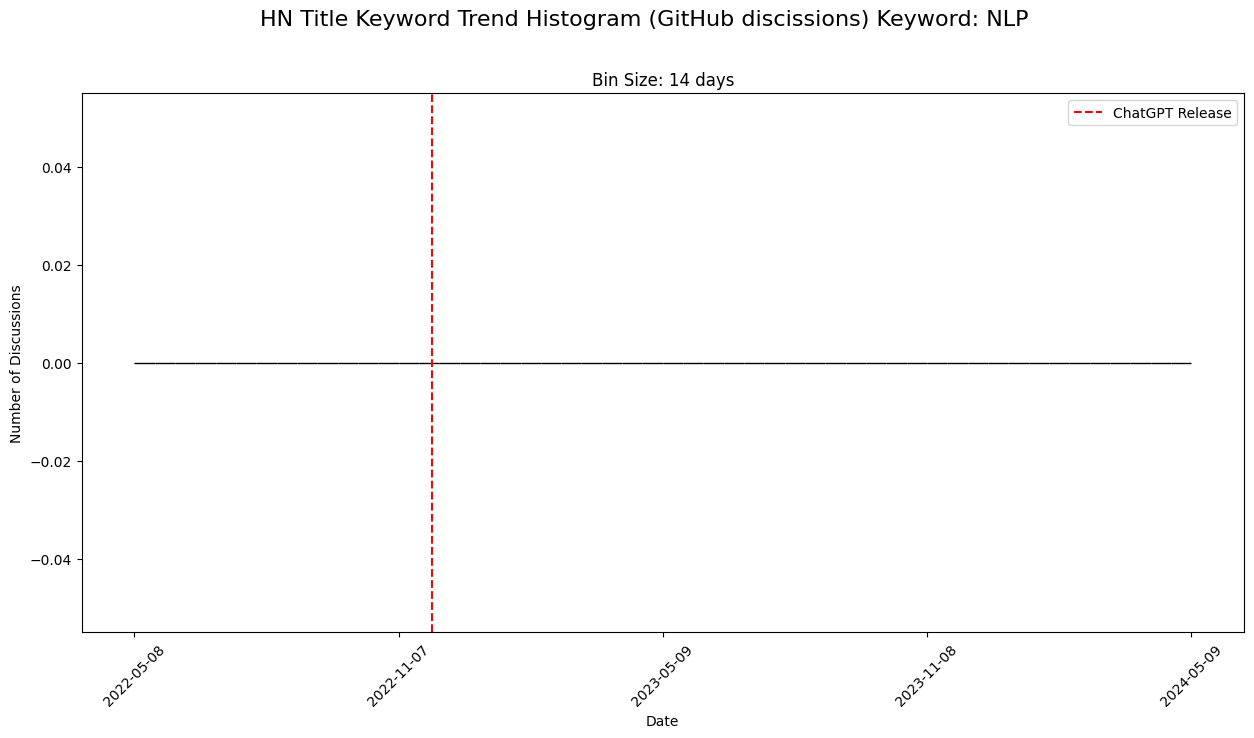

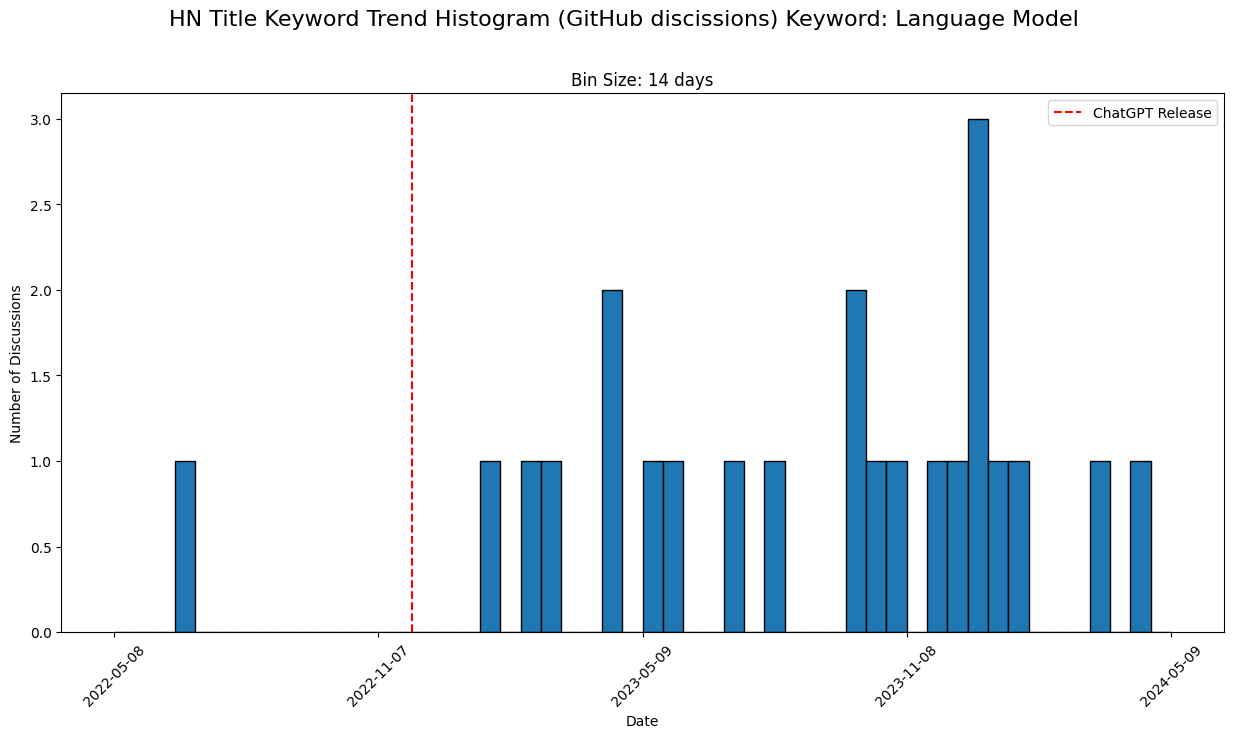

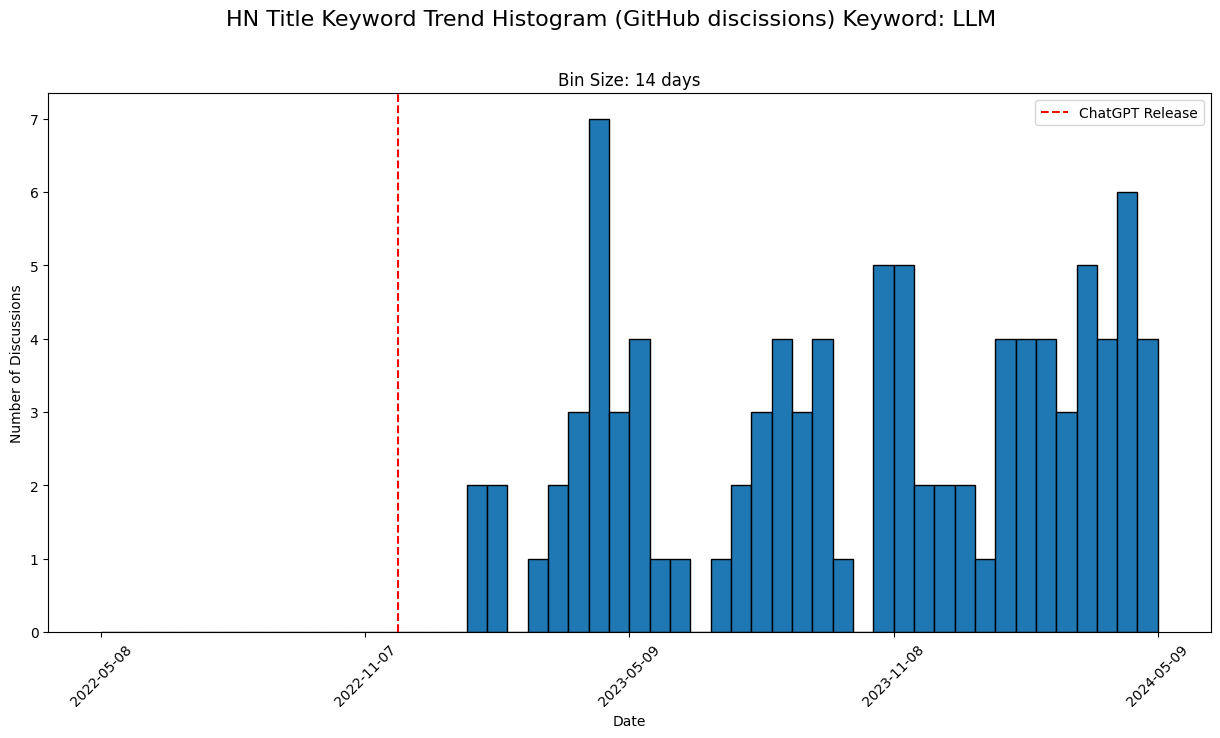

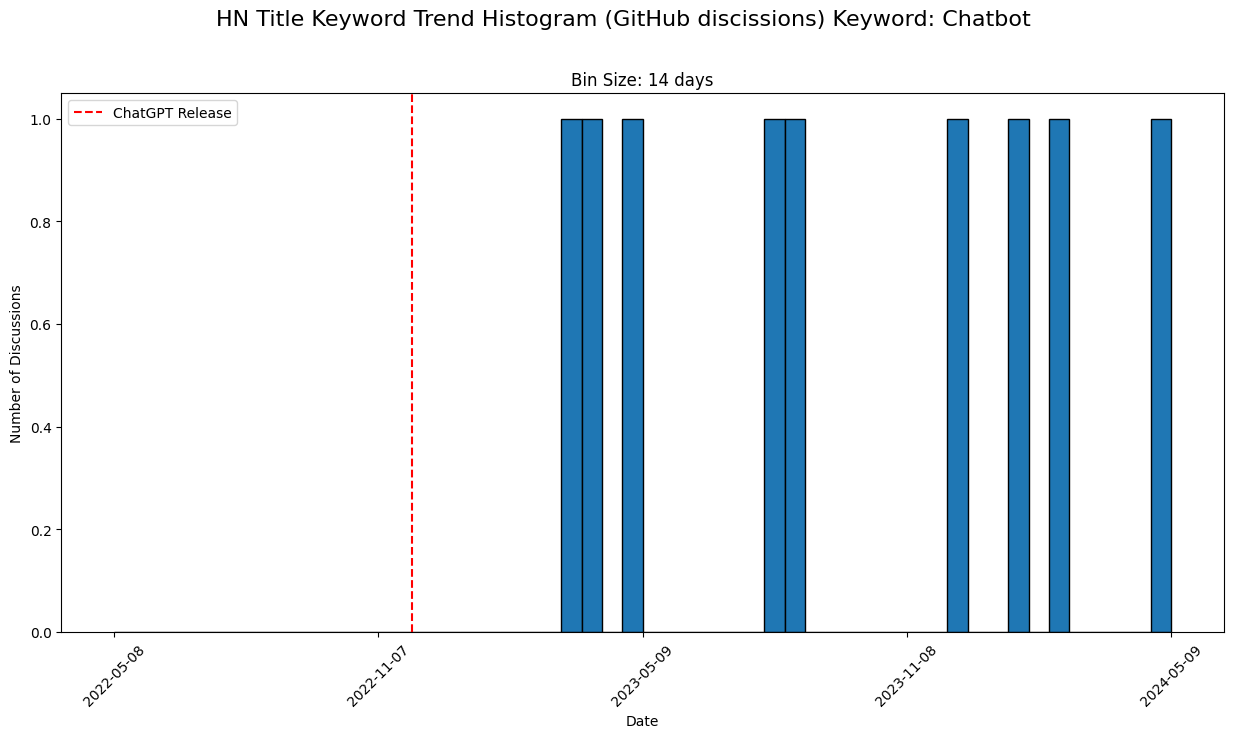

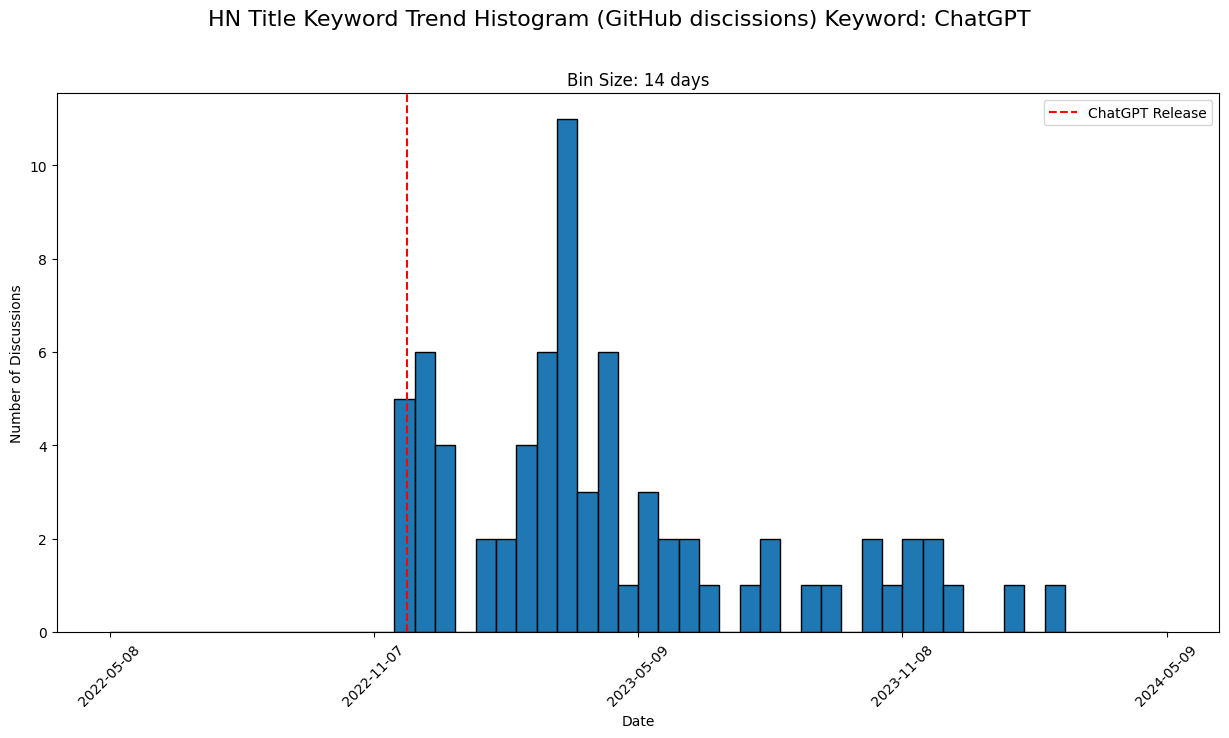

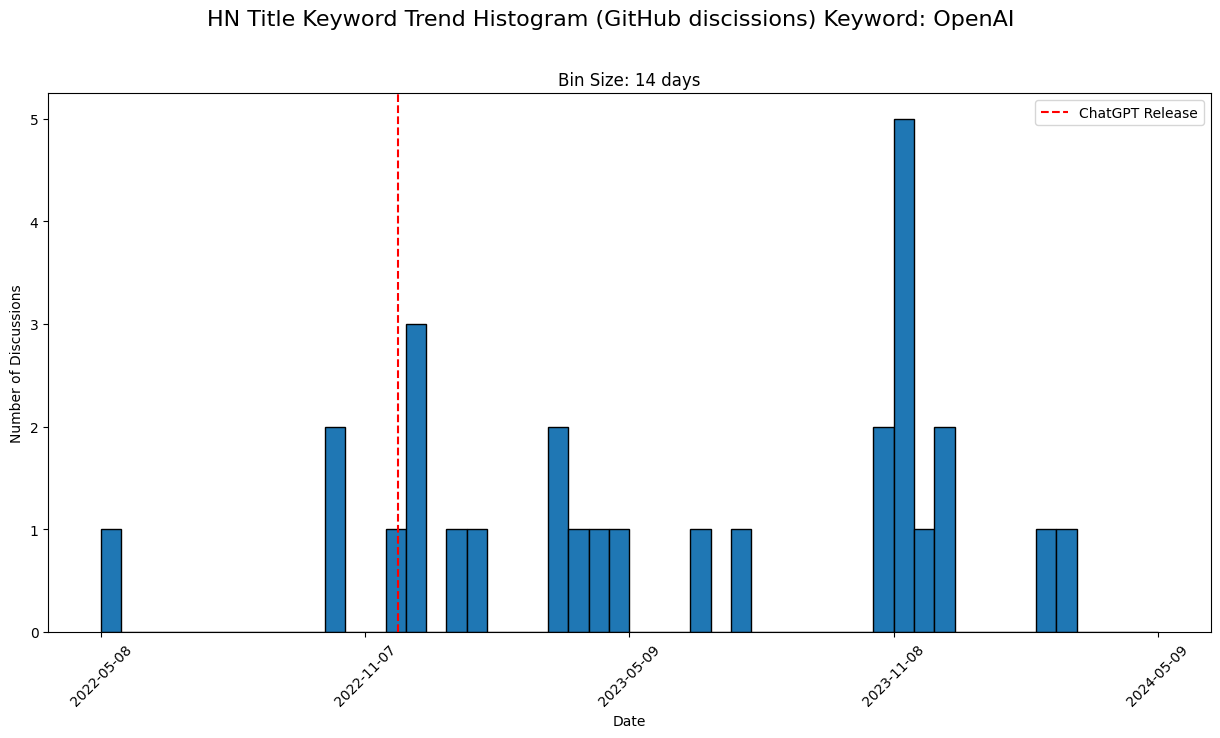

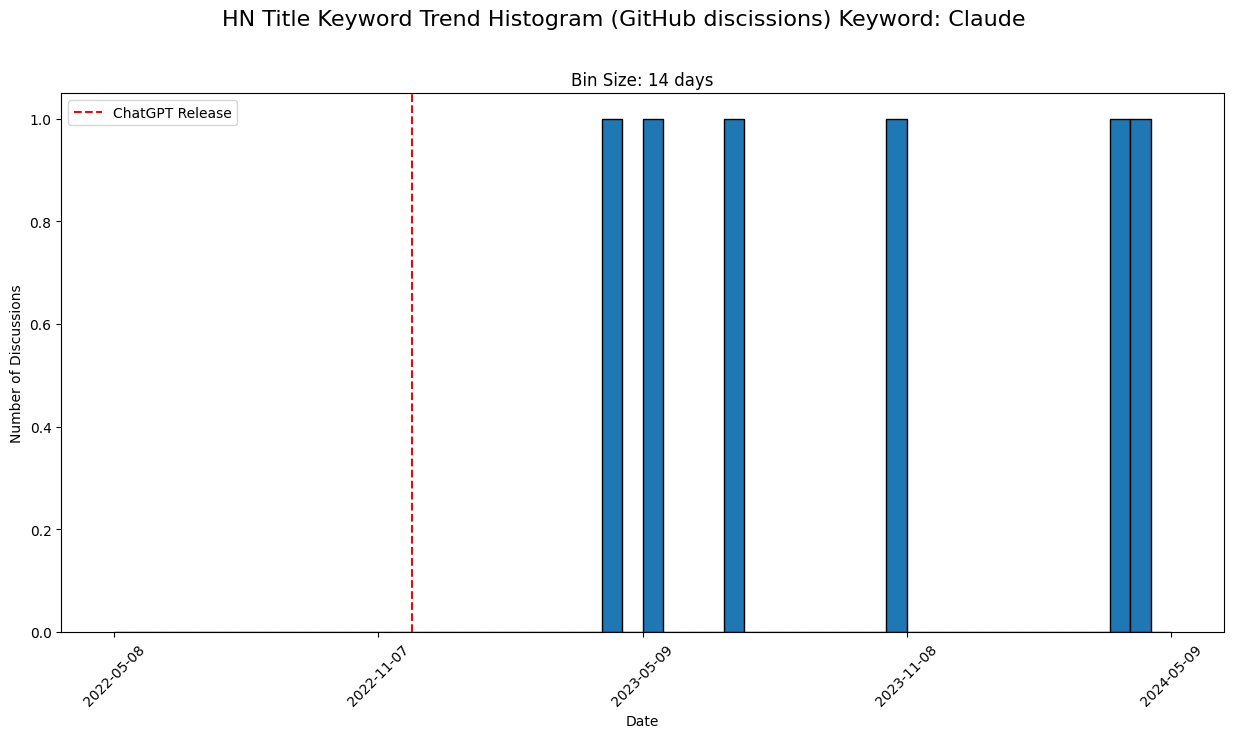

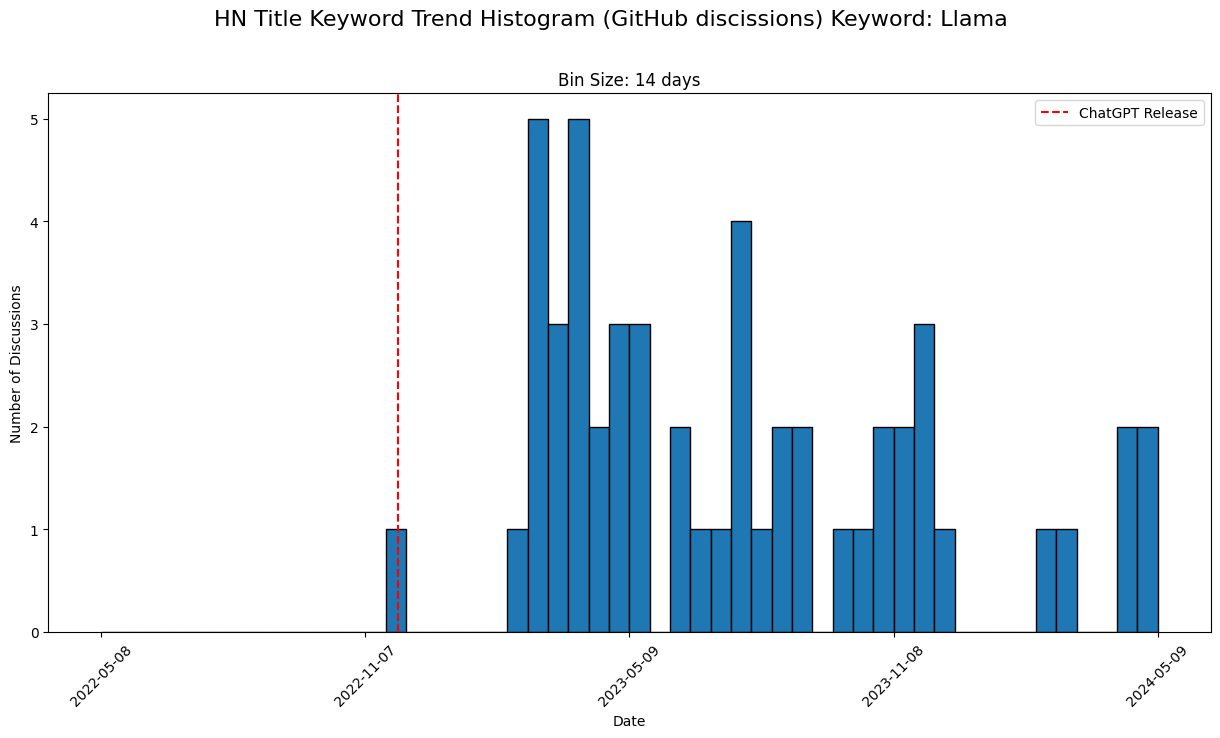

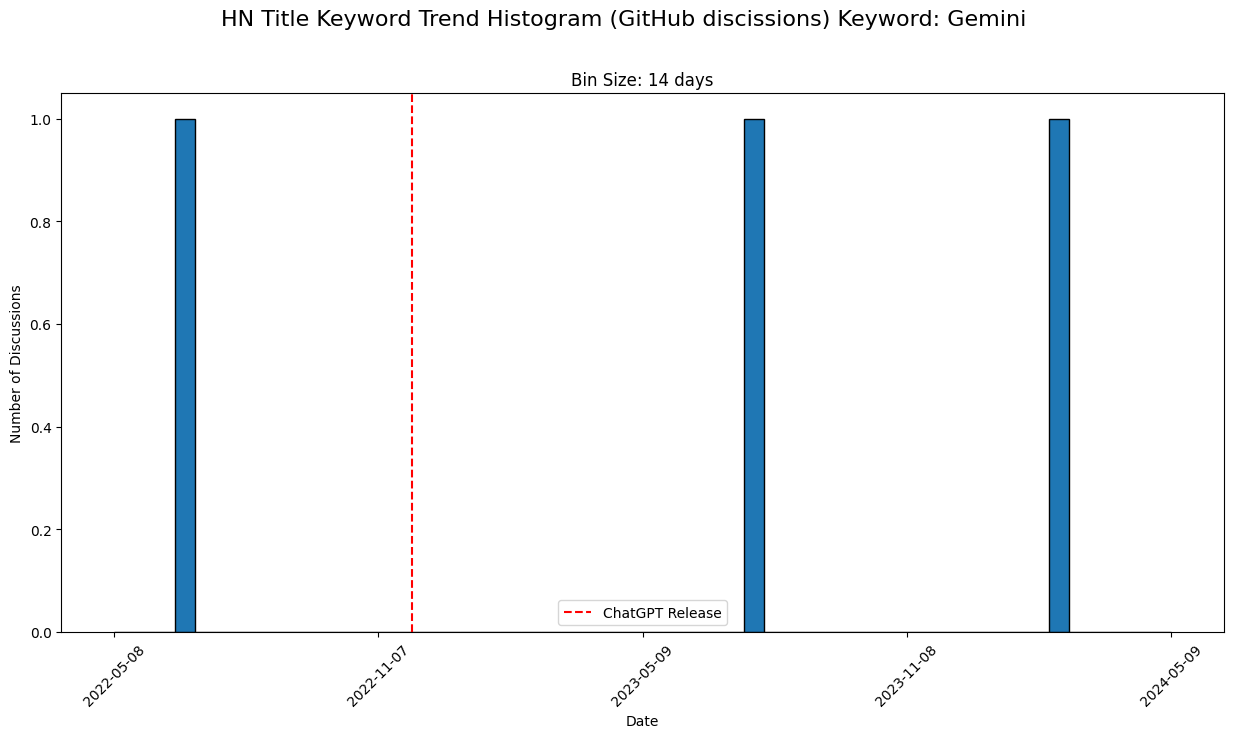

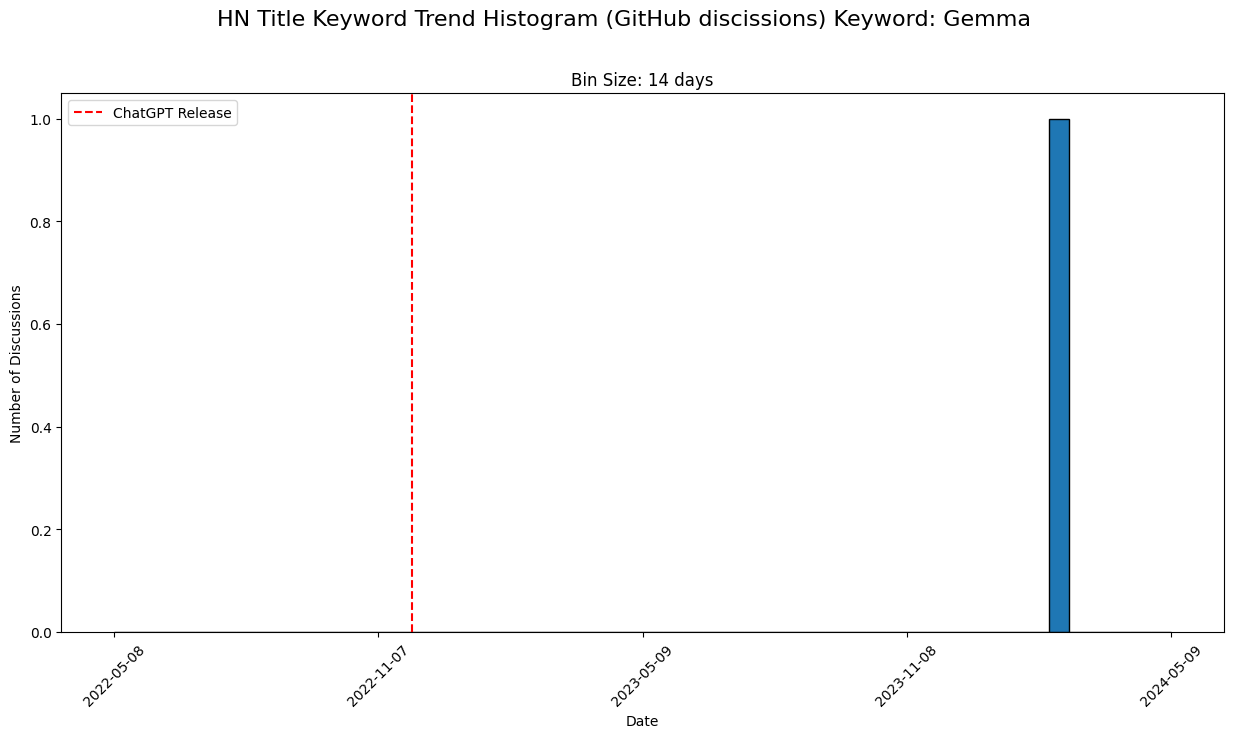

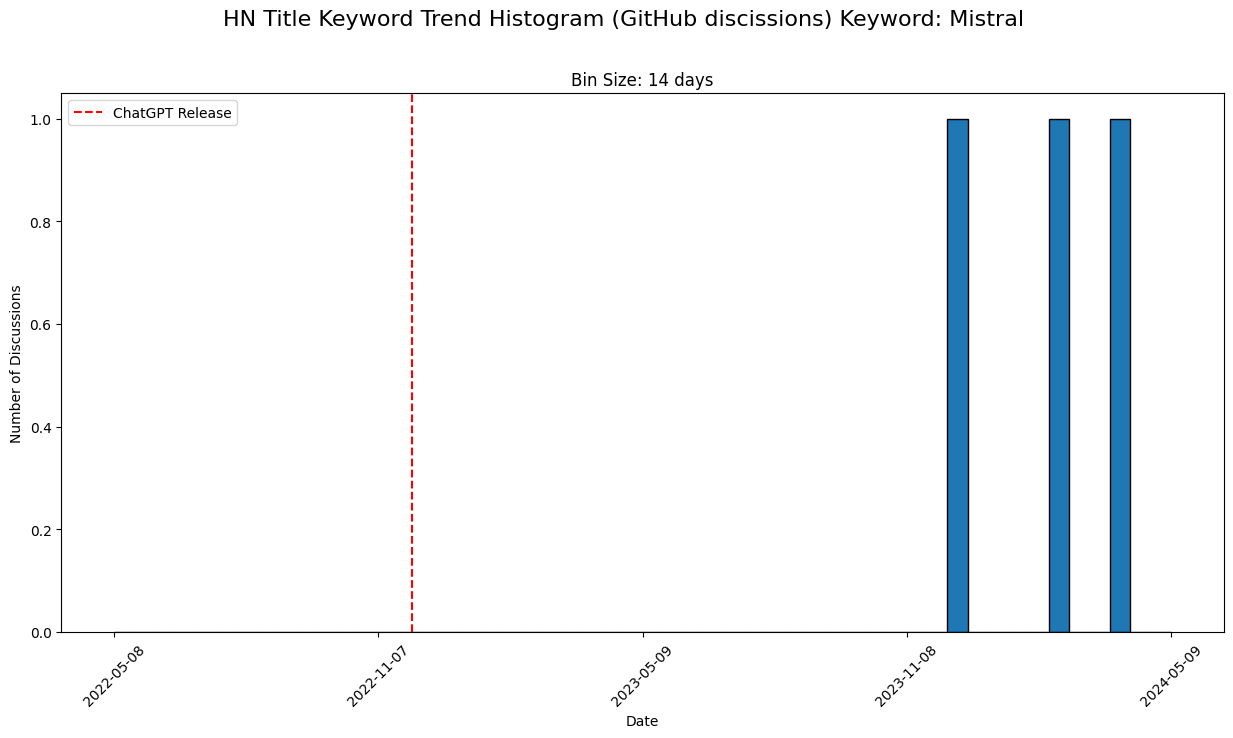

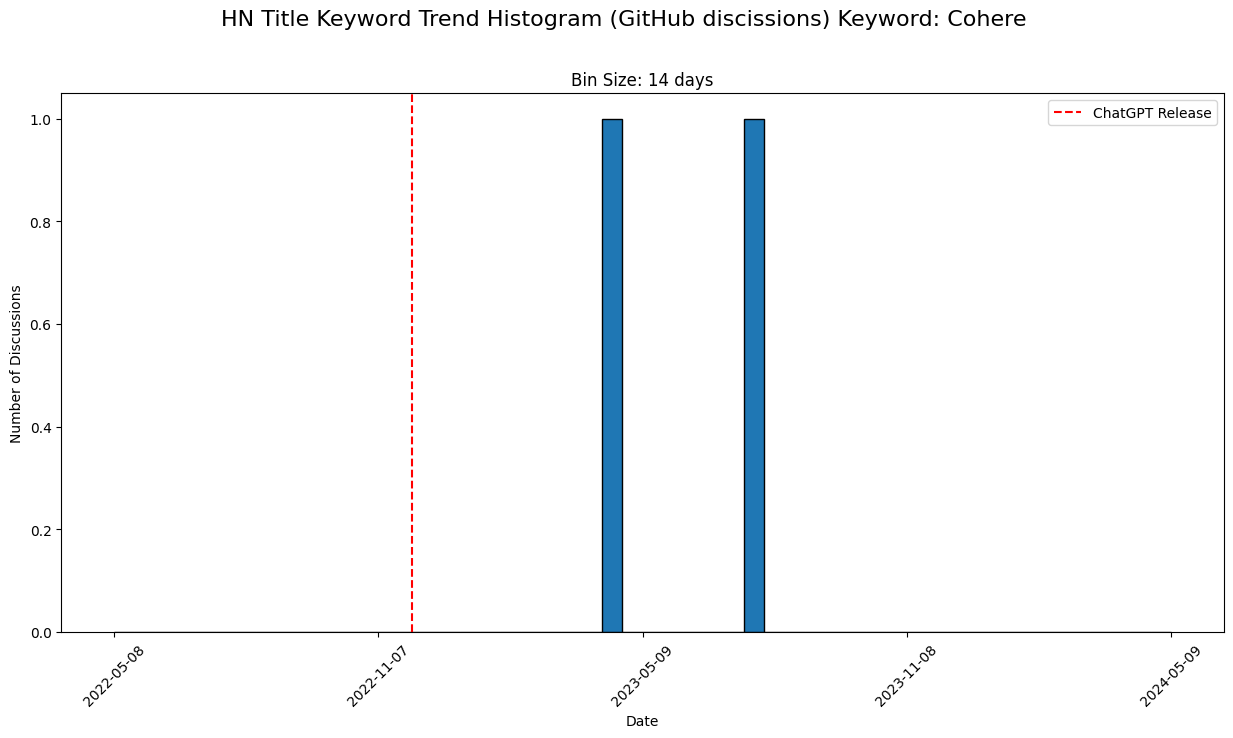

In [ ]:
for keyword in keywords:
    plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (GitHub discissions)', HN_STORIES_GH_CSV, keyword=keyword)

# plot_discussions_histogram_keywords('HN Title Keyword Trend Histogram (GitHub discissions)', HN_STORIES_GH_CSV, keyword='ai')

### plot combined keywords

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 17})

def plot_combined_keyword_trends(title, csv_file_path, keywords):
    """
    Plot multiple keywords' trends over time in a single line graph.

    Args:
    title (str): The graph's title
    csv_file_path (str): The path to the CSV file
    keywords (list): List of keywords to plot
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Set bin size to 14 days
    bin_size_days = 14
    total_days = (end_date - start_date) / (24 * 60 * 60)
    bins = int(total_days / bin_size_days)

    # Create the figure with larger size for better readability
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create bin edges
    bin_edges = np.linspace(start_date, end_date, bins + 1)

    # Plot line for each keyword
    for keyword in keywords:
        # Filter the dataframe based on the keyword
        keyword_df = df[df['title'].str.contains(keyword, case=False, regex=True)]

        # Create histogram data
        hist, _ = np.histogram(keyword_df['date'], bins=bin_edges)

        # Calculate the center of each bin for x-axis
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot the line
        ax.plot(bin_centers, hist, label=keyword, marker='o', markersize=3, linewidth=2)

    # Format x-axis ticks as dates
    def timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    num_ticks = 8  # Increased number of ticks for better temporal resolution
    tick_locations = np.linspace(start_date, end_date, num_ticks)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations], rotation=45)

    # Add ChatGPT release line
    chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
    ax.axvline(x=chatgpt_release, color='red', linestyle='--')

    # Customize the plot
    # ax.set_title(f'{title}\nBin Size: {bin_size_days} days', pad=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Discussions')

    # Create a separate legend for ChatGPT release line
    chatgpt_legend = ax.legend([plt.Line2D([0], [0], color='red', linestyle='--')],
                               ['ChatGPT Release'],
                               loc='upper left', fontsize=14, frameon=True)
    ax.add_artist(chatgpt_legend)

    # Optimize legend placement and formatting for keywords
    ax.legend(bbox_to_anchor=(-0.04, -0.6), loc='lower left', borderaxespad=0.,
              title='Keywords', title_fontsize=18, fontsize=18, ncol=4)

    # Add grid
    ax.grid(visible=True, alpha=0.7)

    # Save and show the plot
    plt.savefig('hn_trends_keywords_combined.png', bbox_inches='tight', dpi=300)
    plt.show()

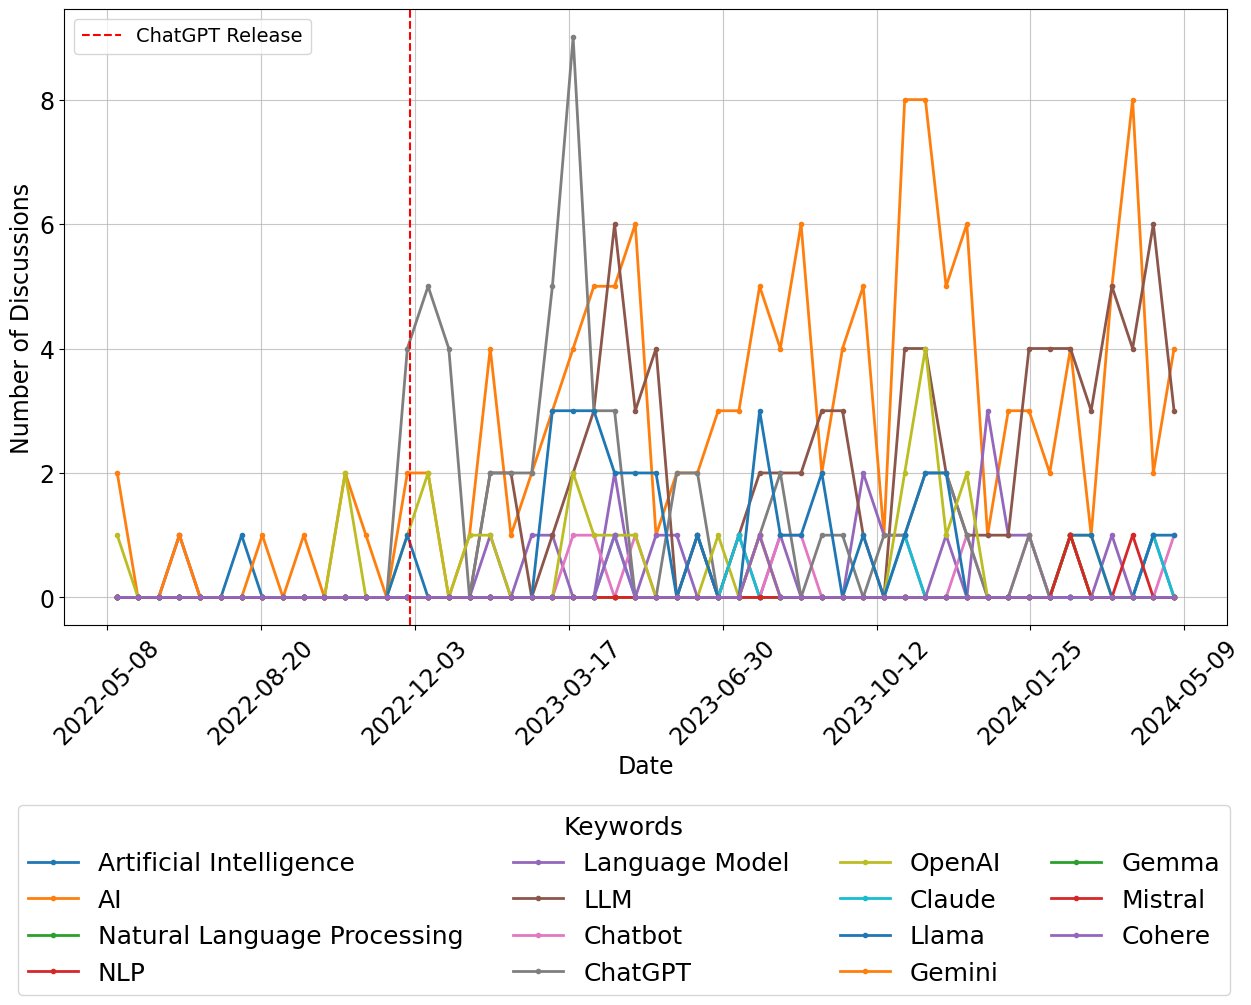

In [ ]:
plot_combined_keyword_trends(
    # 'HN Title Keyword Trends (GitHub discussions)',
    '',
    HN_STORIES_GH_CSV,
    keywords
)